In [2]:
import sys
import ase
from ase.io import read
import numpy as np
import mpmath
import scipy
from scipy import special
import itertools
import math
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc as pltrc
from scipy.interpolate import interp1d
%matplotlib inline
from sympy.physics.wigner import wigner_3j

# Set parameters

In [123]:
# SOAP PARAMETERS
nmax = 20             # number of radial functions
lmax = 6              # number of angular functions
rc = 3.0              # environment cutoff
rk = .98              # killing cutoff
sg = 0.3              # Gaussian width
cen = ["O"]           # atoms to center on
cw = 1.0              # central atom weight
lam = 0               # spherical tensor order
periodic = False       # True for periodic systems

# BUILT IN PARAMETERS
nnmax = 40             # Max number of neighbours
ncell = 2              # number of cell repetitions for periodic systems
ngrid = 1000           # number of points radial 1D-mesh
dr = rc/(ngrid-1)      # spacing 1D-mesh
nsmax = 26             # max number of species (up to iron)
atom_valence = {"H": 1,"He": 2,"Li": 3,"Be": 4,"B": 5,"C": 6,"N": 7,"O": 8,"F": 9,"Ne": 10,"Na": 11,"Mg": 12,"Al": 13,"Si": 14,"P": 15,"S": 16,"Cl": 17,"Ar": 18,"K": 19,"Ca": 20,"Sc": 21,"Ti": 22,"V": 23,"Cr": 24,"Mn": 25,"Fe": 26,"Co": 27,"Ni": 28,"Cu": 29,"Zn": 30} 
atom_symbols = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K', 20: 'Ca', 21: 'Sc', 22: 'Ti', 23: 'V', 24: 'Cr', 25: 'Mn', 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu', 30: 'Zn'}

# Read coordinates and initialize kernel computation

In [124]:
start = time.time()

xyzfile = read("coords_1000_monomer.xyz",':')[998:1000]
npoints = len(xyzfile)
all_names = [xyzfile[i].get_chemical_symbols() for i in range(npoints)]
coords = [xyzfile[i].get_positions() for i in range(npoints)]

# Process input names
full_names_list = [name for sublist in all_names for name in sublist]
unique_names = list(set(full_names_list))
nspecies = len(unique_names)

# List all species according to their valence
all_species = []
for k in unique_names:
    all_species.append(atom_valence[k]) 

# List number of atoms for each configuration
natmax = len(max(all_names, key=len))
nat = np.zeros(npoints,dtype=int)
for i in range(npoints):
    nat[i] = len(all_names[i])

# List indices for atom of the same species for each configuration
atom_indexes = [[[] for j in range(nsmax)] for i in range(npoints)]
for i in range(npoints):
    for ii in range(nat[i]):
        for j in all_species:
            if all_names[i][ii] == atom_symbols[j]:
                atom_indexes[i][j].append(ii)

if len(cen) == 0 :
    centers = all_species
else:
    centers = [atom_valence[i] for i in cen]
    
end = time.time()
print("total =",end-start)

total = 0.42077207565307617


# Do neighbour list

In [125]:
start = time.time()

alpha = 1.0/(2*sg**2)
length = np.zeros((npoints,natmax,nspecies,nnmax), dtype=float )
efact = np.zeros((npoints,natmax,nspecies,nnmax), dtype=float )
harmonic = np.zeros((lmax+1,2*lmax+1,npoints,natmax,nspecies,nnmax), dtype=complex )
nneigh = np.zeros((npoints,natmax,nspecies), dtype=int )
nat    = np.zeros( npoints, dtype=int )

if periodic == False:
    
    # Loop over configurations
    for i in range(npoints):
        iat = 0
        # Loop over species to center on
        for k in centers:
            nat[i] += len(atom_indexes[i][k])
            # Loop over centers of that species
            for l in atom_indexes[i][k]:
                # Loop over all the spcecies to use as neighbours 
                ispe = 0
                for ix in all_species:
                    n=0
                    # Loop over neighbours of that species
                    for m in atom_indexes[i][ix]:
                        rrm = coords[i][m] 
                        rr  = rrm - coords[i][l]
                        # Is it a neighbour within the spherical cutoff ?
                        if np.dot(rr,rr) <= rc**2: 
                            # Central atom?
                            if m == l:
                                length[i,iat,ispe,n]  = 0.0
                                efact[i,iat,ispe,n]   = cw
                                harmonic[0,0,i,iat,ispe,n] = special.sph_harm(0,0,0,0)
                                nneigh[i,iat,ispe] += 1
                                n +=1
                            else:
                                length[i,iat,ispe,n]  = np.linalg.norm(rr)
                                theta   = np.arccos(rr[2]/length[i,iat,ispe,n])
                                phi     = np.arctan2(rr[1],rr[0])
                                efact[i,iat,ispe,n]   = np.exp(-alpha*length[i,iat,ispe,n]**2)
                                for lval in range(lmax+1): 
                                    mrange = np.arange(-lval,lval+1)
                                    harm = np.conj(special.sph_harm(mrange,lval,phi,theta))
                                    for im in range(2*lval+1):
                                        harmonic[lval,im,i,iat,ispe,n] = harm[im]
                                nneigh[i,iat,ispe] += 1
                                n+=1
                    ispe += 1
                iat +=1
                
else:
        
    # Loop over configurations
    for i in range(npoints):
        # Get unit cell
        cell = xyzfile[i].get_cell()
        iat = 0
        # Loop over species to center on
        for k in centers:
            nat[i] += len(atom_indexes[i][k])
            # Loop over centers of that species
            for l in atom_indexes[i][k]:
                # Loop over all the spcecies to use as neighbours 
                ispe = 0
                for ix in all_species:
                    n=0
                    # Loop over neighbours of that species
                    for m in atom_indexes[i][ix]:
                        rr  = coords[i][m] - coords[i][l]
                        # Apply minimum image convention assuming orthorombic cell and rcut < box/2
                        rr[0] -= cell[0,0] * int(round(rr[0] / cell[0,0]))
                        rr[1] -= cell[1,1] * int(round(rr[1] / cell[1,1]))
                        rr[2] -= cell[2,2] * int(round(rr[2] / cell[2,2]))
                        if np.dot(rr,rr) <= rc**2: 
                            # Central atom?
                            if m == l:
                                length[i,iat,ispe,n]  = 0.0
                                efact[i,iat,ispe,n]   = cw
                                harmonic[0,0,i,iat,ispe,n] = special.sph_harm(0,0,0,0)
                                nneigh[i,iat,ispe] += 1
                                n +=1
                            else:
                                length[i,iat,ispe,n]  = np.linalg.norm(rr)
                                theta   = np.arccos(rr[2]/length[i,iat,ispe,n])
                                phi     = np.arctan2(rr[1],rr[0])
                                efact[i,iat,ispe,n]   = np.exp(-alpha*length[i,iat,ispe,n]**2)
                                for lval in range(lmax+1): 
                                    mrange = np.arange(-lval,lval+1)
                                    harm = np.conj(special.sph_harm(mrange,lval,phi,theta))
                                    for im in range(2*lval+1):
                                        harmonic[lval,im,i,iat,ispe,n] = harm[im]
                                nneigh[i,iat,ispe] += 1
                                n+=1
                    ispe += 1
                iat +=1

end = time.time()
print("total =",end-start)

total = 0.002324342727661133


# Compute Lowdin orthogonalization matrix

In [132]:
sigma = np.zeros(nmax,float)
dsigma = 0.12*rc/float(nmax)
sigma[0] = 0.1*rc/float(nmax)
for i in range(1,nmax):
    sigma[i] = sigma[i-1] + dsigma

overlap = np.zeros((nmax,nmax),float)
for n1 in range(nmax):
    for n2 in range(nmax):
        overlap[n1,n2] = (0.5/(sigma[n1])**2 + 0.5/(sigma[n2])**2)**(-0.5*(3.0 +n1 +n2)) \
                         /(sigma[n1]**n1 * sigma[n2]**n2)*\
                          special.gamma(0.5*(3.0 + n1 + n2))/ (  \
                (sigma[n1]*sigma[n2])**1.5 * np.sqrt(special.gamma(1.5+n1)*special.gamma(1.5+n2)) )    

eigenvalues, unitary = np.linalg.eig(overlap)
sqrteigen = np.sqrt(eigenvalues) 
diagoverlap = np.diag(sqrteigen)
newoverlap = np.dot(np.conj(unitary),np.dot(diagoverlap,unitary.T))
orthomatrix = np.linalg.inv(newoverlap)

# Plot radial functions

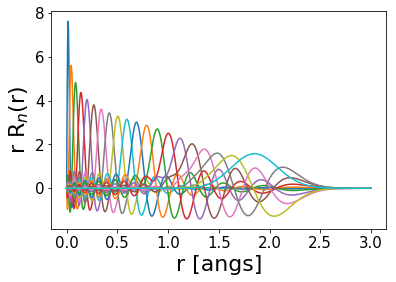

In [133]:
def gauss(rval,sigma,nval):
    """Evaluate normalized Gaussian function"""
    f = np.sqrt(2.0/(special.gamma(1.5+nval)*sigma**(3.0+2.0*nval)))*rval**nval*np.exp(-(rval)**2/(2*sigma**2))
    return f

radial = np.zeros((nmax,ngrid),dtype=float)
rvec = np.zeros(ngrid,float)
for n in range(nmax):        
    for ir in range(ngrid):
        r = ir*dr
        rvec[ir] = r
        radial[n][ir] = gauss(r,sigma[n],n)
            
newradial = np.dot(orthomatrix,radial) 

rradial = np.zeros((nmax,ngrid),dtype=float)
for ir in range(ngrid):
    r = ir*dr
    for n in range(nmax):
        rradial[n,ir] = newradial[n,ir] * r 
        
for n in range(nmax):
    plt.plot(rvec,rradial[n])

matplotlib.rcParams.update({'font.size': 22})
pltrc('xtick', labelsize=15) 
pltrc('ytick', labelsize=15) 
plt.xlabel("r [angs]")
plt.ylabel("r R$_n$(r)")
plt.show()

# Check ortho-normality: $\int_0^{r_\text{cut}} dr\ r^2\ R_n(r)\ R_{n'}(r) = \delta_{nn'}$

In [138]:
over = 0.0
for ir in range(ngrid):
    r = ir*dr
    over += r*r*radial[2][ir]*radial[2][ir]
over *= dr
print("Overlap primitive = "+str(over)) 

over = 0.0
for ir in range(ngrid):
    r = ir*dr
    over += r*r*newradial[1][ir]*newradial[0][ir]
over *= dr
print("Overlap orthogonal = "+str(over)) 

Overlap primitive = 1.0000000000000007
Overlap orthogonal = 5.292516902805066e-06


# Compute analytic integrals of primitive radial functions

# $c_{nl}(\mathcal X_c,i) = \exp\left\{-\frac{r_i^2}{2\sigma^2}\right\}\times \int_0^{r_\text{cut}} dr\ r^2\ g_n(r)\ \exp\left\{-\frac{r^2}{2\sigma^2}\right\}\times \iota_l\left(\frac{rr_i}{\sigma^2}\right)$

In [139]:
start = time.time()
sg2 = sg**2
radint = np.zeros((nmax,lmax+1,npoints,natmax,nspecies,nnmax),float)
for n in range(nmax):        
    normfact = np.sqrt(2.0/(special.gamma(1.5+n)*sigma[n]**(3.0+2.0*n)))
    sigmafact = (sg2**2+sg2*sigma[n]**2)/sigma[n]**2
    for l in range(lmax+1):
        radint[n,l,:,:,:,:] = efact[:,:,:,:] \
                            * 2.0**(-0.5*(1.0+l-n)) \
                            * (1.0/sg2 + 1.0/sigma[n]**2)**(-0.5*(3.0+l+n)) \
                            * special.gamma(0.5*(3.0+l+n))/special.gamma(1.5+l) \
                            * (length[:,:,:,:]/sg2)**l \
                            * special.hyp1f1(0.5*(3.0+l+n), 1.5+l, 0.5*length[:,:,:,:]**2/sigmafact)   
    radint[n] *= normfact
radint *= np.sqrt(np.pi)
end = time.time()
print(end-start)

0.009078025817871094


# Orthogonalize integrated radial functions $c'_{nl}(\mathcal X_c,i) = \sum_{n'}S_{nn'}^{-1/2}c_{n'l}(\mathcal X_c,i)$

In [140]:
start = time.time()
orthoradint = np.einsum("nb,bliash->lniash",orthomatrix,radint)
end = time.time()
print(end-start)

0.001657247543334961


# Compute expansion coefficients

# $\omega^\alpha_{nlm}(\mathcal X_c) = \sum_i c'_{nl}(\mathcal X_c,i)\ Y^{\star}_{lm}(\mathcal X_c,i)$

In [141]:
start = time.time()
omega = np.einsum('lniash,lmiash->iaslmn',orthoradint,harmonic)
end = time.time()
print(end-start)

0.004453182220458984


# Compute the $\lambda$-SOAP power spectrum 

# $P^{\lambda\mu}_{\alpha,\beta,n,n',l,l'}(\mathcal X_c) = \sum_m \omega^{\alpha}_{nlm}(\mathcal X_c)\ \omega^{\beta\star}_{n'l'(m-\mu)}(\mathcal X_c)\times (-1)^m
\ 3J(\lambda,l',l;\mu,m-\mu,-m)$



In [142]:
start = time.time()

if lam==0:
                
    # PRECOMPUTE OMEGA CONJUGATE
    omegatrue = np.zeros((npoints,natmax,nspecies,nmax,lmax+1,2*lmax+1),complex)
    omegaconj = np.zeros((npoints,natmax,nspecies,nmax,lmax+1,2*lmax+1),complex)
    for l in range(lmax+1):
        for m in range(2*l+1):
            omegatrue[:,:,:,:,l,m] = omega[:,:,:,l,m,:]/np.sqrt(np.sqrt(2*l+1))
            omegaconj[:,:,:,:,l,m] = np.conj(omega[:,:,:,l,m,:])/np.sqrt(np.sqrt(2*l+1))
                     
    # COMPUTE POWER SPECTRUM
    power = np.einsum('iasblm,iadnlm->iasdbnl',omegatrue,omegaconj)
    power = power.reshape(npoints,natmax,nspecies*nspecies*nmax**2*(lmax+1))

    
    #NORMALIZE POWER SPECTRUM
    for i in range(npoints):
        for iat in range(nat[i]):
            inner = np.real(np.dot(power[i,iat],np.conj(power[i,iat])))
            power[i,iat] /= np.sqrt(inner)   
                
    power = power.reshape(npoints*natmax,nspecies*nspecies*nmax**2*(lmax+1))
    
else:
    
    # PRECOMPUTE WIGNER-3J SYMBOLS
    w3j = np.zeros((lmax+1,lmax+1,2*lmax+1,2*lam+1),float)
    for l1 in range(lmax+1):
        for l2 in range(lmax+1):
            for m in range(2*l1+1):
                for mu in range(2*lam+1):
                    w3j[l1,l2,m,mu] = wigner_3j(lam,l2,l1,mu-lam,m-l1-mu+lam,-m+l1)* (-1.0)**(m-l1)
                    
    # PRECOMPUTE OMEGA CONJUGATE
    omegaconj = np.zeros((npoints,natmax,nspecies,nmax,lmax+1,2*lmax+1,2*lam+1),complex)
    for l in range(lmax+1):
        for m in range(2*l+1):
            for mu in range(2*lam+1):
                omegaconj[:,:,:,:,l,m,mu] = np.conj(omega[:,:,:,l,m-mu,:])
                           
    # COMPUTE POWER SPECTRUM
    power = np.einsum('iaslvn,iadmkvx,lkvx->iaxsdnmlk',omega,omegaconj,w3j)
    power = power.reshape(npoints,natmax,2*lam+1,nspecies*nspecies*nmax**2*(lmax+1)**2) 
    
    #NORMALIZE POWER SPECTRUM
    for i in range(npoints):
        for iat in range(nat[i]):
            inner = 0.0
            for mu in range(2*lam+1):
                inner += np.real(np.dot(power[i,iat,mu],np.conj(power[i,iat,mu])))
            power[i,iat] /= np.sqrt(inner)   
                
    power = power.reshape(npoints*natmax*(2*lam+1),nspecies*nspecies*nmax**2*(lmax+1)**2)

end = time.time()
print(end-start)

0.006984233856201172


# Compute kernel of local environments

# $k^{\lambda}_{\mu\nu}(\mathcal X_c,\mathcal X'_{c'}) = \sum_{\alpha\beta n n' l l'} P^{\lambda\mu}_{\alpha,\beta,n,n',l,l'}(\mathcal X_c)\ P^{\lambda\nu\star}_{\alpha,\beta,n,n',l,l'}(\mathcal X'_{c'})$

In [143]:
start = time.time()
kernel = np.dot(power[:],np.conj(power[:].T))
end = time.time()
print(end-start)
if lam==0:
    print(np.real(kernel[kernel!=0]))
else:
    print(kernel[kernel!=0])

0.0022192001342773438
[1.         0.99872577 0.99872577 1.        ]


In [ ]:
[ 1.          0.98118783  0.98537256 ...,  0.95434726  0.98941646  1.        ]

# Expected kernel for $n \to \infty$ for the last two structures:

1.0 

0.998725770104

0.998725770104  

1.0